In [1]:
import os
import warnings

import pandas as pd
import numpy as np
import datetime as dt

import statsmodels.api as sm 
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import mplfinance as mpf

plt.style.use('seaborn-whitegrid')
warnings.filterwarnings("ignore")

In [2]:
def read_file(dir_list, folder_path):
    file_list=[]
    for filename in dir_list: 
        file_list.append(pd.read_csv(folder_path + filename))

    df = pd.concat(file_list)
    df.reset_index(inplace = True, drop = True)
    df['Date'] = pd.to_datetime(df['Date'])
    # df.set_index('Date', inplace = True)
    return df

In [3]:
#construct variables for 1 ticker
def create_variable(df):
    #endogenous
    df['pricechange'] = df['close'].diff()
    df['ret'] = np.log(df['close']).diff()
    #exogenous
    df['lag1_ret'] = df['ret'].shift()
    df['lag2_ret'] = df['ret'].shift(2)
    df['volumeGap'] = np.log(df['volume']).diff()
    df['fractHigh'] = (df['high'] - df['open']) / df['open']
    df['fractLow'] = (df['open'] - df['low']) / df['open']
    df.dropna(inplace=True)
    
    return df

def split_train_test(df, testNum = 80):
    return df.iloc[:-testNum], df.iloc[-testNum:]

In [4]:
folder_path = 'D:/Database/Crypto data/_coin_api/'
dir_list = os.listdir(folder_path)
# print(dir_list)
df = read_file(dir_list, folder_path)

In [5]:
df.set_index('Date', inplace = True, drop = False)

In [6]:
df_train = df.loc['2021-03-01' : '2021-05-14']
df_test = df.loc['2021-05-15' :]

In [7]:
group_df_train = df_train.groupby([df_train.Date.dt.hour, df_train.Date.dt.minute]).mean()
train = create_variable(group_df_train)
train = train.droplevel(level = 0)
train.reset_index(drop = True, inplace = True)
train.head()

group_df_test = df_test.groupby([df_test.Date.dt.hour, df_test.Date.dt.minute]).mean()
test = create_variable(group_df_test)
test = test.droplevel(level = 0)
test.reset_index(drop = True, inplace = True)
test.head()

,open,high,low,close,volume,trade_count,pricechange,ret,lag1_ret,lag2_ret,volumeGap,fractHigh,fractLow
0,3231.44500,3250.49750,3222.86500,3238.86750,3664.819431,8763.500,7.21625,0.002231,0.005946,0.036029,-0.429986,0.005896,0.002655
1,3238.87000,3255.57625,3220.96500,3240.75625,3760.038450,9470.125,1.88875,0.000583,0.002231,0.005946,0.025650,0.005158,0.005528
2,3240.83625,3250.12375,3216.24375,3227.55250,3096.227170,8343.625,-13.20375,-0.004083,0.000583,0.002231,-0.194245,0.002866,0.007588
3,3227.67000,3238.73500,3209.85250,3218.22000,3856.204647,8966.000,-9.33250,-0.002896,-0.004083,0.000583,0.219499,0.003428,0.005520
4,3218.16125,3238.35250,3200.50125,3214.00000,5162.313284,10533.750,-4.22000,-0.001312,-0.002896,-0.004083,0.291701,0.006274,0.005488


In [8]:
endog_train, exog_train, exog_ochl_train = abs(train['ret']), abs(train[['lag1_ret', 'lag2_ret']]), train[['volumeGap','fractHigh', 'fractLow']]
# endog_test, exog_test, exog_ochl_test = test['ret'], test[['lag1_ret','lag2_ret']], test[['volumeGap','fractHigh', 'fractLow']]

In [9]:
# Include exog variables: lag 1, lag 2
mod = sm.tsa.MarkovRegression(endog=endog_train, k_regimes=2, exog=exog_train, trend = 'nc', 
                            switching_variance=True).fit()

In [10]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                    ret   No. Observations:                  285
Model:               MarkovRegression   Log Likelihood                1712.356
Date:                Sat, 03 Jul 2021   AIC                          -3408.711
Time:                        14:35:16   BIC                          -3379.491
Sample:                             0   HQIC                         -3396.998
                                - 285                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lag1_ret       0.1279      0.029      4.434      0.000       0.071       0.184
lag2_ret       0.1166      0.021      5.465      0.000       0.075       0.158
sigma2      1.984e-07        nan        nan        nan         nan         nan
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lag1_ret       0.4510      0.207      2.174      0.030       0.044       0.858
lag2_ret       1.1713      0.467      2.510      0.012       0.257       2.086
sigma2      1.681e-05   6.32e-06      2.661      0.008    4.43e-06    2.92e-05
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9425      0.018     53.528      0.000       0.908       0.977
p[1->0]        0.8780      0.111      7.898      0.000       0.660       1.096
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [11]:
mod.smoothed_marginal_probabilities

,0,1
0,4.011019e-125,1.000000
1,6.360380e-20,1.000000
2,9.996969e-01,0.000303
3,9.961590e-01,0.003841
4,9.848199e-01,0.015180
...,...,...
280,9.933533e-01,0.006647
281,9.937478e-01,0.006252
282,9.920214e-01,0.007979
283,9.906353e-01,0.009365


<AxesSubplot:>

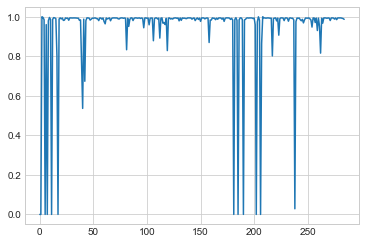

In [12]:
mod.smoothed_marginal_probabilities[0].plot()

In [ ]:
tranM = np.empty((2, 2))
tranM[:1] = np.array(mod.params[mod.params.index.str.contains('p')]).reshape(1, 2)
tranM[-1] = 1 - np.array(mod.params[mod.params.index.str.contains('p')]).reshape(1, 2).sum(axis=0)

In [ ]:
xparam = mod.params[mod.params.index.str.contains('x')]
nExog = int(len(xparam) / 2)
xparam = np.array(xparam).reshape(nExog, 2)

In [ ]:
params = mod.params
cparam = params[params.index.str.contains('c')]
cparam = np.array(cparam)

In [ ]:
last_prob = mod.smoothed_marginal_probabilities.iloc[-1, :]

In [ ]:
last_prob

In [ ]:
tranM

In [ ]:
np.dot(last_prob, tranM.T)

In [ ]:
# Include exog variables: lag 1, lag 2
mod = sm.tsa.MarkovRegression(endog=endog_train, k_regimes=2, exog=exog_train, trend='nc', 
                            switching_trend=True,
                            switching_exog=True,
                            switching_variance=True).fit()

In [ ]:
mod.summary()

In [ ]:
mod.smoothed_marginal_probabilities[0].plot()

In [ ]:
mod.smoothed_marginal_probabilities[1].plot()

In [ ]:
# No exog variables
mod = sm.tsa.MarkovRegression(endog=endog_train, k_regimes=2, trend='nc', 
                            switching_trend=True,
                            switching_variance=True).fit()

In [ ]:
mod.summary()

In [ ]:
mod.smoothed_marginal_probabilities[0].plot()

In [ ]:
mod.smoothed_marginal_probabilities[1].plot()

In [ ]:
mod.params

In [ ]:
    def betaMatrix(self):
        '''k*k beta matrix, each row contains one beta under each regime'''
        if self.exog is not None:
            params = self.mod.params
            xparam = params[params.index.str.contains('x')]
            nExog = int(len(xparam) / self.k)
            xparam = np.array(xparam).reshape(nExog, self.k)
            return xparam
        else:  
            return 0